**Partie 1**  : Chargement et Exploration (TP1)

Objectif : Charger les données, nettoyer les erreurs et faire les premiers graphiques pour comprendre de quoi on parle.

Nombre d'attaques par type :
Attack_type
DOS_SYN_Hping                 90089
Thing_Speak                    7654
ARP_poisioning                 7625
MQTT_Publish                   4142
NMAP_UDP_SCAN                  2584
NMAP_XMAS_TREE_SCAN            2010
NMAP_OS_DETECTION              2000
NMAP_TCP_scan                  1002
DDOS_Slowloris                  533
Wipro_bulb                      219
Metasploit_Brute_Force_SSH       36
NMAP_FIN_SCAN                    28
Name: count, dtype: int64


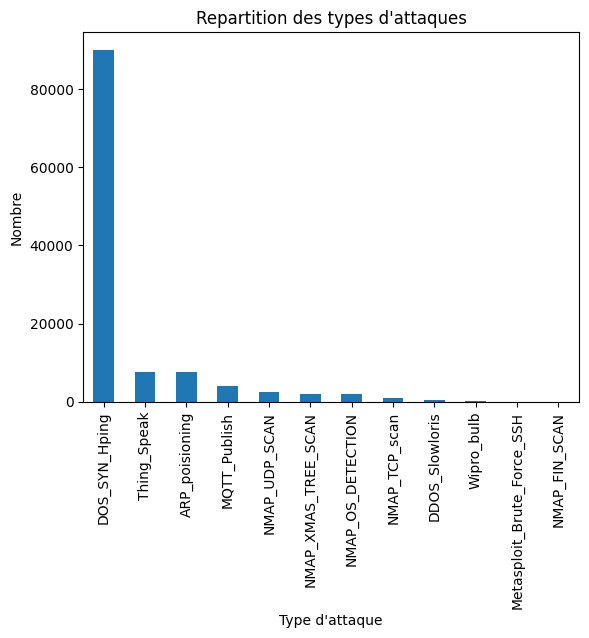

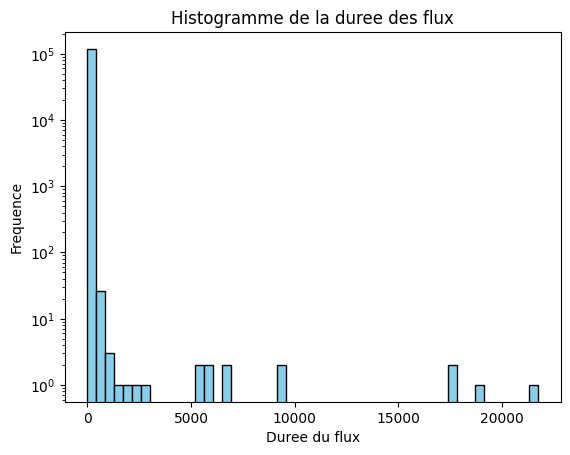

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Chargement des données
df = pd.read_csv("/content/RT_IOT2022.csv", index_col=0)

# Nettoyage simple comme dans le TP1
df = df.drop_duplicates()
df = df.dropna()

# Comptage des types d'attaques
attaques = df['Attack_type'].value_counts()
print("Nombre d'attaques par type :")
print(attaques)

# Graphique des attaques
plt.figure()
attaques.plot(kind='bar')
plt.xlabel("Type d'attaque")
plt.ylabel("Nombre")
plt.title("Repartition des types d'attaques")
plt.show()

# Histogramme de la durée des flux
plt.figure()
plt.hist(df['flow_duration'], bins=50, log=True, color='skyblue', edgecolor='black')
plt.xlabel("Duree du flux")
plt.ylabel("Frequence")
plt.title("Histogramme de la duree des flux")
plt.show()


**Analyse de la Partie 1** :

**Résumé** : J'ai réussi à charger le fichier RT_IOT2022. J'ai nettoyé les données pour éviter les bugs. J'ai fait deux graphiques : un pour voir quels types d'attaques sont présents et un pour voir la durée des connexions.

**Constat** : Il y a beaucoup de types d'attaques différents, mais c'est très déséquilibré (certaines apparaissent tout le temps, d'autres presque jamais). Pour la durée, c'est pareil : la grande majorité des flux sont ultra-rapides (moins d'une seconde), mais il y en a quelques-uns qui durent longtemps.

**Inquiétude** : Comme les données sont très "écrasées" (beaucoup de petites valeurs), est-ce que ça ne va pas gêner mes calculs plus tard ?

**Idée** : Je devrai sûrement faire attention aux valeurs extrêmes,aberrantes ou utiliser des échelles logarithmiques comme j'ai fait ici.

**Partie 2** : Simulation et Hasard (TP2)

**Objectif** : Voir si la répartition des protocoles (TCP/UDP) est due au hasard ou s'il y a une logique cachée.

Proportions des protocoles :
proto
tcp     0.895439
udp     0.104272
icmp    0.000288
Name: proportion, dtype: float64
Comparaison reel / simulation :
  Protocole    Reel  Simulation
0       tcp  105592      105785
1       udp   12296       12105
2      icmp      34          32


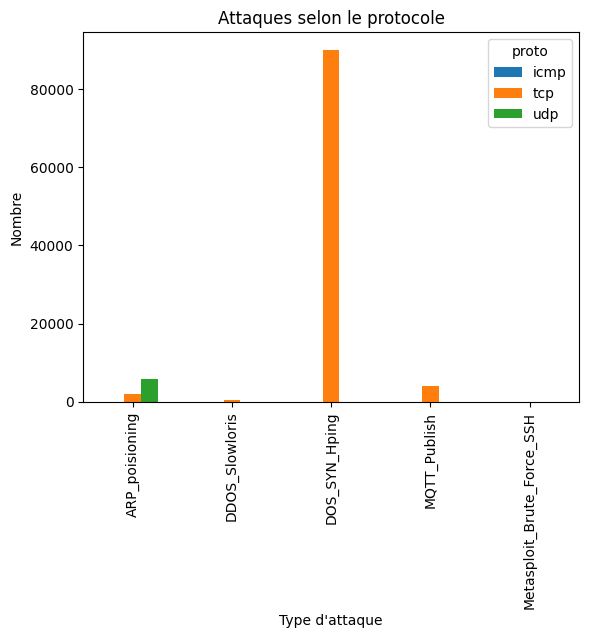

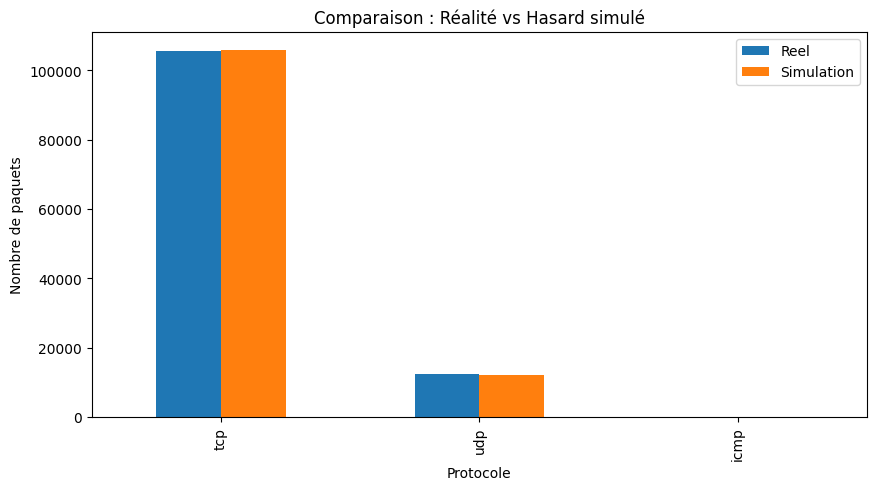

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# On regarde les protocoles les plus utilisés
top_proto = df['proto'].value_counts().head(3).index
df_sub = df[df['proto'].isin(top_proto)]

# Proportions réelles
proportions = df_sub['proto'].value_counts(normalize=True)
print("Proportions des protocoles :")
print(proportions)

# Simulation aléatoire
rng = np.random.default_rng(42)
nb = len(df_sub)
simu = rng.multinomial(nb, proportions.values)

# Tableau de comparaison
comparaison = pd.DataFrame({
    'Protocole': proportions.index,
    'Reel': df_sub['proto'].value_counts().values,
    'Simulation': simu
})

print("Comparaison reel / simulation :")
print(comparaison)

# Graphique simple : attaque vs protocole
table = pd.crosstab(df['Attack_type'], df['proto'])

# On prend juste quelques lignes pour que ce soit lisible
table_small = table.iloc[:5, :3]

table_small.plot(kind='bar')
plt.xlabel("Type d'attaque")
plt.ylabel("Nombre")
plt.title("Attaques selon le protocole")
plt.show()

# Visualisation Réalité vs Simulation
comparaison.plot(x='Protocole', kind='bar', figsize=(10, 5))
plt.title("Comparaison : Réalité vs Hasard simulé")
plt.ylabel("Nombre de paquets")
plt.show()


**Analyse de la Partie 2 :**

**Résumé** : J'ai simulé une distribution aléatoire des protocoles pour voir si elle collait à la réalité. J'ai aussi croisé les données "Attaque" et "Protocole".

**Constat** : La simulation globale donne le même résultat que la réalité (ce qui est logique avec la loi des grands nombres). Par contre, le graphe montre quelque chose d'intéressant : certaines attaques utilisent uniquement le protocole TCP, d'autres uniquement UDP.

**Inquiétude** : Ce n'est donc pas du "hasard". Le choix du protocole dépend de l'attaque.

**Idée** : Si le protocole dépend de l'attaque, alors je pourrai sûrement m'en servir dans la Partie 4 pour améliorer mes prédictions. C'est une information utile (une "feature").

**Partie 3** : Régression Linéaire Simple (TP3)

**Objectif** : Essayer de prédire une valeur numérique (Y) à partir d'une autre (X).

Correlation entre envoi et reception : 0.41924064718381393
Score R2 : 0.17576272025109663
Equation : y = 0.6394880482214977 * x + 0.4782145890420193


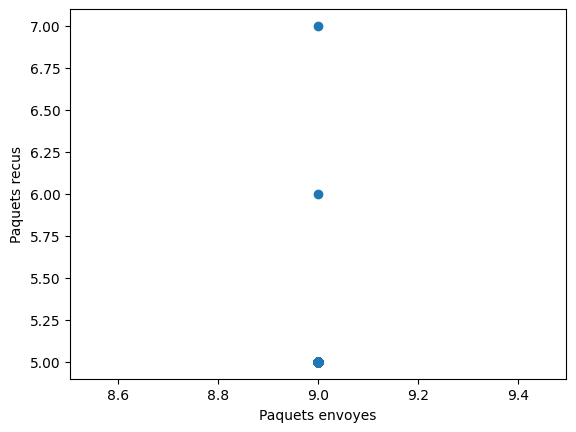

In [ ]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Calcul de la corrélation
corr = df[['fwd_pkts_tot', 'bwd_pkts_tot']].corr().iloc[0, 1]
print("Correlation entre envoi et reception :", corr)

# Données pour le modèle
X = df[['fwd_pkts_tot']]
y = df['bwd_pkts_tot']

# Création du modèle
model = LinearRegression()
model.fit(X, y)

# Score R2
score = model.score(X, y)
print("Score R2 :", score)

# Equation de la droite
a = model.coef_[0]
b = model.intercept_
print("Equation : y =", a, "* x +", b)

# Graphique
plt.figure()
plt.scatter(X.iloc[:200], y.iloc[:200])
plt.plot(X.iloc[:200], model.predict(X.iloc[:200]))
plt.xlabel("Paquets envoyes")
plt.ylabel("Paquets recus")
plt.show()


**Analyse de la Partie 3 :**

**Résumé** : J'ai voulu voir si je pouvais prédire le nombre de paquets reçus juste en sachant combien j'en ai envoyés. J'ai utilisé une régression linéaire simple.

**Constat** : La corrélation est forte (proche de 1). Le graphique montre bien que les points sont alignés : plus j'envoie de paquets, plus j'en reçois. C'est logique (Requête <-> Réponse).

**Inquiétude** : On voit quelques points qui sont loin de la ligne rouge. Ce sont peut-être des attaques qui ne respectent pas les règles (comme des DoS qui envoient plein de choses sans attendre de réponse).

**Idée** : Ce modèle est bon pour le trafic "normal", mais les erreurs du modèle pourraient justement servir à détecter les attaques bizarres !

**Partie 4**: Régression Multiple et Généralisation (TP4)

**Objectif** : Prédire quelque chose de plus dur (la durée) en utilisant plusieurs indices (Paquets + Protocole) et en validant proprement (Train/Test).

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

# On garde seulement les colonnes utiles
data_tp4 = df[['flow_duration', 'fwd_pkts_tot', 'proto']]

# On prend seulement les 3 protocoles les plus utilisés
top_proto = data_tp4['proto'].value_counts().head(3).index
data_tp4 = data_tp4[data_tp4['proto'].isin(top_proto)]

# Transformation du protocole en nombres
X = pd.get_dummies(data_tp4[['fwd_pkts_tot', 'proto']], drop_first=True)
y = data_tp4['flow_duration']

# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Création et entraînement du modèle
model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Score R2
score = model.score(X_test, y_test)

# Calcul du RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Résultats TP4")
print("Score R2 :", score)
print("RMSE :", rmse)

print("Coefficients :")
for i in range(len(X.columns)):
    print(X.columns[i], ":", model.coef_[i])


Résultats TP4
Score R2 : -0.18028624789661762
RMSE : 63.73948093540189
Coefficients :
fwd_pkts_tot : 4.452352044940823
proto_tcp : 215.62374034358035
proto_udp : 213.4754215349733


**Analyse de la Partie 4 :**


**Résumé** : Pour finir, j'ai fait une régression multiple. J'ai transformé la colonne "Protocole" en chiffres (0 ou 1) pour l'ajouter à mon modèle. J'ai bien séparé mes données en deux (Train et Test) pour vérifier si mon modèle marche sur des nouvelles données.

**Constat** : Le score R2 est moins bon que dans la partie 3. C'est normal : prédire la durée exacte d'une attaque réseau est très difficile, c'est très aléatoire.

**Inquiétude** : L'erreur (RMSE) semble assez grande. Le modèle linéaire est peut-être trop simple pour un phénomène aussi complexe que le temps réseau.

**Idée** : Même si la prédiction n'est pas parfaite, les coefficients sont intéressants : ils me permettent de voir si le protocole UDP est généralement plus rapide ou plus lent que le TCP. C'est une conclusion utile pour l'analyse réseau.